## Setup and Import Configuration

In [1]:
%reset -f
%reload_ext autoreload
%autoreload 2

In [ ]:
# Import common utilities
from common_imports import *

# Import ALL configuration variables from config file
from Default_SQCONFIG_for_X_GATE import *

# Import additional functions
from hamiltonian_builder import construct_TD_SAHam
from atom_basis import make_initial_list_for_gate_fidelity
from fidelity_calculator import (
    compute_state_fidelity, 
    compute_gate_fidelity_mixed,
)
from plotting_helpers import (
    plot_population_evolution,
    plot_multiple_population_evolution,
    plot_fidelity_vs_parameter,
    plt_config
)

In [4]:
# Apply plotting configuration
plt.rcParams.update(plt_config)

## Check Imported Configuration Variables

In [6]:
print("=" * 70)
print("Configuration Summary")
print("=" * 70)
print(f"Pulse parameters:")
print(f"  sigma = {sigma} μs")
print(f"  t0 = {t0} μs")
print(f"  Omega01 = {Omega01} MHz")
print(f"\nTime list:")
print(f"  Number of points: {len(tlist)}")
print(f"  Total time: {tlist[-1]:.2f} μs")
print(f"\nLindblad parameters:")
print(f"  gamma_r = {lindblad_params['gamma_r']:.6f}")
print(f"\nFidelity calculation:")
print(f"  dim_qubits = {dim_qubits}")
print(f"  comp_indices = {comp_indices}")
print("=" * 70)

Configuration Summary
Pulse parameters:
  sigma = 1.0 μs
  t0 = 10.0 μs
  Omega01 = 1.0 MHz

Time list:
  Number of points: 90
  Total time: 30.00 μs

Lindblad parameters:
  gamma_r = 0.001852

Fidelity calculation:
  dim_qubits = 2
  comp_indices = [0, 1]


---
# Example 1: Simple Population Evolution

Use default configuration parameters directly - no need to redefine anything!

In [7]:
# Construct Hamiltonian using config variables
H0, collapse_list = construct_TD_SAHam(atom0_ham_params, lindblad_params)

# Initial state (from config)
psi0 = state1

# Simulate
result = mesolve(
    H0, psi0, tlist, collapse_list, expect_list,
    options={"store_final_state": True, "store_states": False}
)

print(f"✅ Simulation completed with {len(tlist)} time points")

✅ Simulation completed with 90 time points


d:\anaconda3\envs\my_qiskit\Lib\site-packages\qutip\solver\solver_base.py:583: FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
  warnings.warn(


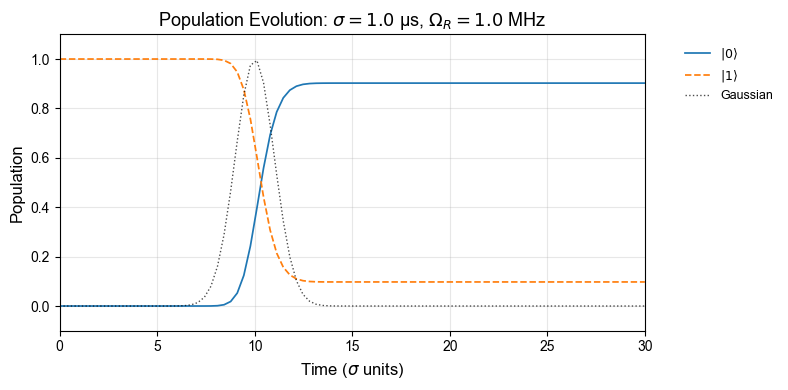

In [9]:
# Plot population evolution
pop_list = [result.expect[0], result.expect[1]]
legend_list = [r"$|0\rangle$", r"$|1\rangle$"]

fig, ax = plt.subplots(figsize=(8, 4))
plot_population_evolution(
    ax, scale_tlist, pop_list, legend_list,
    plot_pulse=True,
    pulse_dict=global_pulse_dict,
    title=rf"Population Evolution: $\sigma={sigma}$ μs, $\Omega_R={Omega01}$ MHz",
    xlabel=r"Time ($\sigma$ units)"
)
plt.tight_layout()
plt.show()

---
# Example 2: Scan Over Omega01

The `Omega01_list` is already defined in config, so we can directly use it!

In [10]:
print(f"Scanning Omega01: {Omega01_list}")

res_list = []
for Omega01_val in Omega01_list:
    # Modify the amplitude in pulse arguments
    Omega01_pulse_args["Amplitude"] = Omega01_val
    
    # Reconstruct Hamiltonian
    H0, collapse_list = construct_TD_SAHam(atom0_ham_params, lindblad_params)
    
    # Simulate
    result = mesolve(
        H0, state1, tlist, collapse_list, expect_list_comp,
        options={"store_final_state": True, "store_states": False}
    )
    res_list.append(result)

print(f"✅ Completed {len(res_list)} simulations")

Scanning Omega01: [0.0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75]
✅ Completed 8 simulations


d:\anaconda3\envs\my_qiskit\Lib\site-packages\qutip\solver\solver_base.py:583: FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
  warnings.warn(


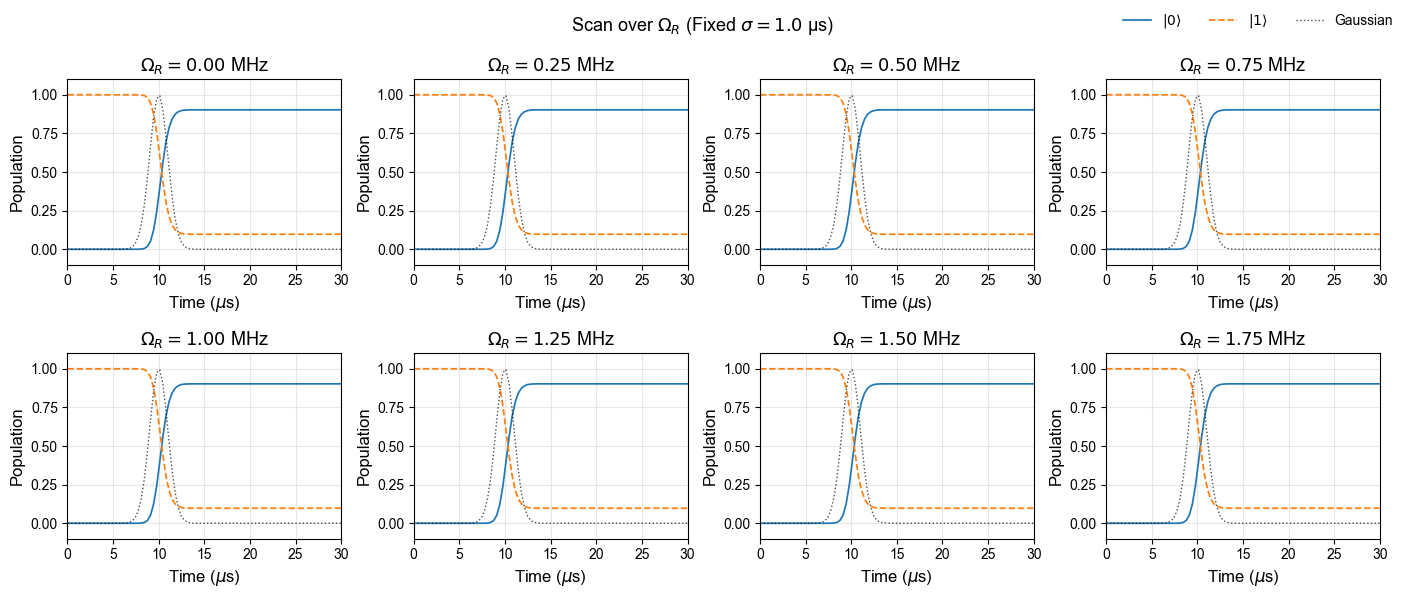

In [11]:
# Plot multiple population evolutions
pop_dict_list = [
    {
        'result': res, 
        'indices': [0, 1], 
        'labels': [r'$|0\rangle$', r'$|1\rangle$'], 
        'sub_title': rf"$\Omega_{{R}}={Omega:.2f}$ MHz"
    }
    for res, Omega in zip(res_list, Omega01_list)
]

fig, axes = plt.subplots(2, 4, figsize=(14, 6))
axes = axes.ravel()

plot_multiple_population_evolution(
    fig, axes, scale_tlist, pop_dict_list,
    suptitle=rf"Scan over $\Omega_R$ (Fixed $\sigma={sigma}$ μs)",
    global_plot_pulse=True,
    global_pulse_dict=global_pulse_dict
)

plt.tight_layout()
plt.show()

---
# Example 3: Scan Over Sigma

The `sigma_list` is also pre-defined in config!

In [12]:
print(f"Scanning sigma: {sigma_list}")

# Fix Omega01 for this scan
Omega01_pulse_args["amp_Omega01"] = 1.0

res_list_sigma = []
for sigma_val in sigma_list:
    # Update sigma and dependent parameters
    t0_val = scale_t0 * sigma_val
    tlist_val = scale_tlist * sigma_val
    
    # Update pulse arguments
    Omega01_pulse_args["sigma"] = sigma_val
    Omega01_pulse_args["t0"] = t0_val
    
    # Reconstruct Hamiltonian
    H0, collapse_list = construct_TD_SAHam(atom0_ham_params, lindblad_params)
    
    # Simulate
    result = mesolve(
        H0, state1, tlist_val, collapse_list, expect_list_comp,
        options={"store_final_state": True, "store_states": False}
    )
    res_list_sigma.append(result)

print(f"✅ Completed {len(res_list_sigma)} simulations")

Scanning sigma: [0.5  0.75 1.   1.25 1.5  2.   4.   8.  ]
✅ Completed 8 simulations


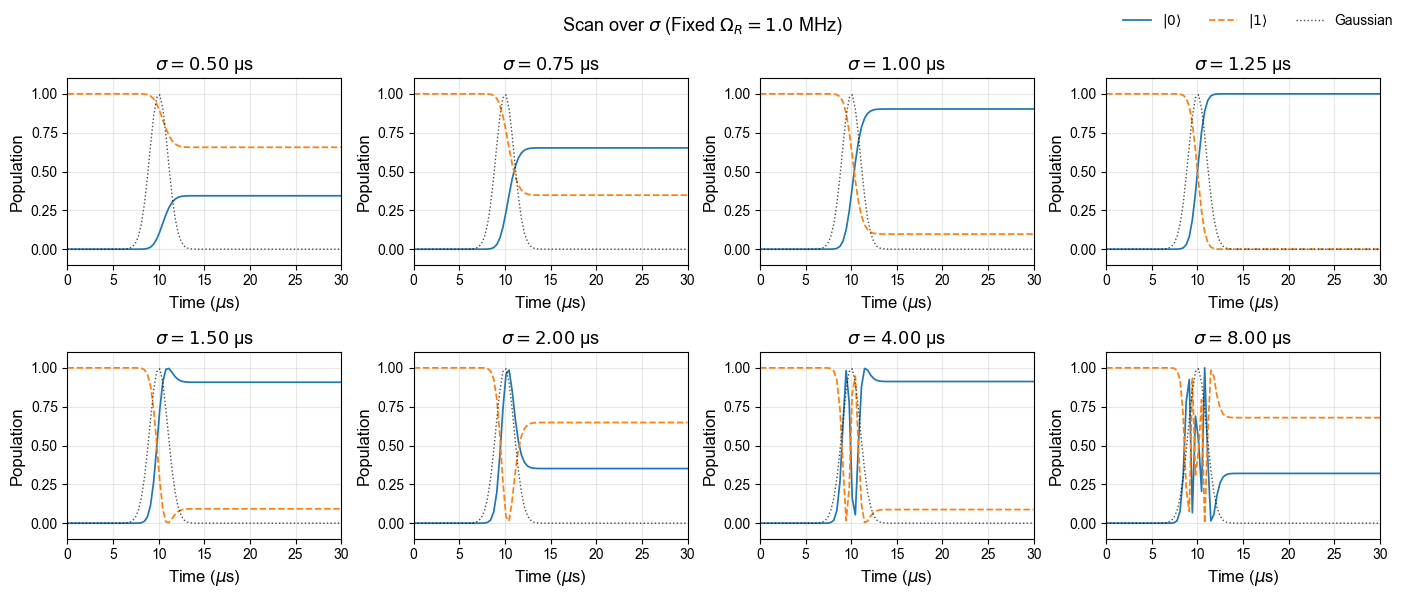

In [13]:
# Plot
pop_dict_list_sigma = [
    {
        'result': res, 
        'indices': [0, 1], 
        'labels': [r'$|0\rangle$', r'$|1\rangle$'], 
        'sub_title': rf"$\sigma={sigma_val:.2f}$ μs"
    }
    for res, sigma_val in zip(res_list_sigma, sigma_list)
]

fig, axes = plt.subplots(2, 4, figsize=(14, 6))
axes = axes.ravel()

plot_multiple_population_evolution(
    fig, axes, scale_tlist, pop_dict_list_sigma,
    suptitle=rf"Scan over $\sigma$ (Fixed $\Omega_R=1.0$ MHz)",
    global_plot_pulse=True,
    global_pulse_dict=global_pulse_dict
)

plt.tight_layout()
plt.show()

---
# Example 4: Fidelity Calculation

All fidelity-related parameters (`dim_qubits`, `comp_indices`, etc.) are already in config!

In [23]:
# Define target gate (X gate)
from qutip import sigmax
target_gate = sigmax()

# Generate initial states using config variables
psi0_list = make_initial_list_for_gate_fidelity(num_qubits, dim_atom)
qs0_list = make_initial_list_for_gate_fidelity(num_qubits, dim_qubits)

print(f"Number of initial states: {len(psi0_list)}")

Omega01_pulse_args["sigma"] = 1.0  # Fix sigma for gate fidelity calculation
Omega01_pulse_args["t0"] = scale_t0 * 1.0  # Update t0 accordingly

Number of initial states: 3


In [24]:
# Calculate fidelity for different Omega01 values
fidelity_mixed_list = []
fidelity_geom_list = []
fidelity_arith_list = []

for Omega01_val in Omega01_list:
    # Update amplitude
    Omega01_pulse_args["amp_Omega01"] = Omega01_val
    
    # Construct Hamiltonian
    H0, collapse_list = construct_TD_SAHam(atom0_ham_params, lindblad_params)
    
    # Compute state fidelities
    state_fidelity_list, _ = compute_state_fidelity(
        qs0_list, target_gate, H0, collapse_list, tlist,
        psi0_list=psi0_list,
        comp_indices=comp_indices,  # from config
        expect_list=None
    )
    
    # Compute gate fidelity (using dim_qubits from config)
    fid_mixed, fid_geom, fid_arith = compute_gate_fidelity_mixed(
        state_fidelity_list, dim_qubits, return_all=True
    )
    
    fidelity_mixed_list.append(fid_mixed)
    fidelity_geom_list.append(fid_geom)
    fidelity_arith_list.append(fid_arith)

print(f"✅ Fidelity calculation completed")
print(f"Best fidelity: {max(fidelity_mixed_list):.6f}")

✅ Fidelity calculation completed
Best fidelity: 0.999994


d:\anaconda3\envs\my_qiskit\Lib\site-packages\qutip\core\data\expm.py:139: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  return Dense(scipy.linalg.sqrtm(matrix.as_ndarray()))


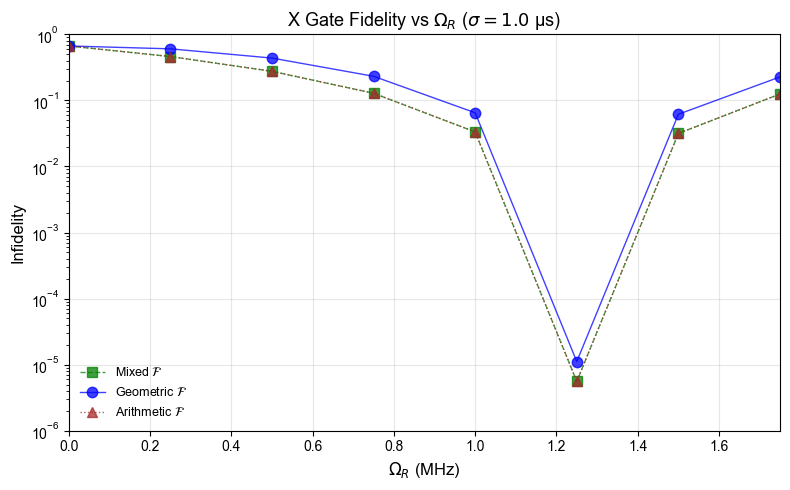

In [28]:
# Plot fidelity vs Omega01
fig, ax = plt.subplots(figsize=(8, 5))

plot_fidelity_vs_parameter(
    ax,
    Omega01_list,
    [fidelity_mixed_list, fidelity_geom_list, fidelity_arith_list],
    [r'Mixed $\mathcal{F}$', r'Geometric $\mathcal{F}$', r'Arithmetic $\mathcal{F}$'],
    title=rf"X Gate Fidelity vs $\Omega_R$ ($\sigma={sigma}$ μs)",
    xlabel=r"$\Omega_R$ (MHz)",
    ylabel="Infidelity",
    use_infidelity=True,
    log_scale=True,
    ylim=(1e-6, 1e0)
)

plt.tight_layout()
plt.show()

In [ ]:
# Plot infidelity on log scale
fig, ax = plt.subplots(figsize=(8, 5))

plot_fidelity_vs_parameter(
    ax,
    Omega01_list,
    [fidelity_mixed_list, fidelity_geom_list, fidelity_arith_list],
    [r'Mixed', r'Geometric', r'Arithmetic'],
    title=rf"X Gate Infidelity vs $\Omega_R$ ($\sigma={sigma}$ μs)",
    xlabel=r"$\Omega_R$ (MHz)",
    ylabel=r"Infidelity ($1-\mathcal{F}$)",
    use_infidelity=True,
    log_scale=True
)

plt.tight_layout()
plt.show()

---
# Example 5: Custom Parameter Override

If you want to use different values temporarily, just reassign the variables in the notebook!

In [ ]:
# Override config variables for this specific test
sigma_custom = 3.0 * time_unit
t0_custom = scale_t0 * sigma_custom
tlist_custom = scale_tlist * sigma_custom
Omega01_custom = 2.5

# Update pulse arguments
Omega01_pulse_args["sigma"] = sigma_custom
Omega01_pulse_args["t0"] = t0_custom
Omega01_pulse_args["Amplitude"] = Omega01_custom

# Construct and simulate
H0, collapse_list = construct_TD_SAHam(atom0_ham_params, lindblad_params)
result_custom = mesolve(
    H0, state1, tlist_custom, collapse_list, expect_list_comp,
    options={"store_final_state": True, "store_states": False}
)

print(f"✅ Custom simulation completed")
print(f"   sigma = {sigma_custom} μs")
print(f"   Omega01 = {Omega01_custom} MHz")

In [ ]:
# Plot custom result
pop_list_custom = [result_custom.expect[0], result_custom.expect[1]]
legend_list = [r"$|0\rangle$", r"$|1\rangle$"]

fig, ax = plt.subplots(figsize=(8, 4))
plot_population_evolution(
    ax, scale_tlist, pop_list_custom, legend_list,
    plot_pulse=True,
    pulse_dict=global_pulse_dict,
    title=rf"Custom Parameters: $\sigma={sigma_custom}$ μs, $\Omega_R={Omega01_custom}$ MHz",
    xlabel=r"Time ($\sigma$ units)"
)
plt.tight_layout()
plt.show()

---
# Summary

## Key Takeaways

1. **Import once, use everywhere**: `from config_single_atom import *`

2. **Pre-defined variables available**:
   - `sigma`, `t0`, `Omega01`, `tlist`, `scale_tlist`
   - `atom0_ham_params`, `lindblad_params`
   - `state0`, `state1`, `stater`, `stated`
   - `expect_list`, `expect_list_comp`
   - `dim_qubits`, `comp_indices`, `num_qubits`
   - `Omega01_list`, `sigma_list`
   - `global_pulse_dict`

3. **Easy to modify**:
   - Edit `config_single_atom.py` for permanent changes
   - Override variables in notebook for temporary changes

4. **Code becomes cleaner**:
   - No repetitive parameter definitions
   - Focus on the physics, not the boilerplate
   - Consistent parameters across different notebooks

## Next Steps

- Copy this pattern to other notebooks
- Add more preset configurations to `config_single_atom.py` as needed
- Create similar config files for two-atom systems if needed